In [1]:
import math
from datetime import datetime

import scipy.stats as stats
from scipy import signal

import numpy as np
import matplotlib.pyplot as plt

from sstudentt import SST

%matplotlib notebook

In [2]:
grid = np.arange(-100, 100, 1)

start = datetime.now()
for i in range(1000):
    pmf1 = stats.t.pdf(grid, df=10, loc=10, scale=10)
    pmf2 = stats.t.pdf(grid, df=10, loc=10, scale=10)
    conv_pmf = signal.fftconvolve(pmf1, pmf2, "same")

print(datetime.now() - start)

0:00:00.413051


In [3]:
DISTRIB_DELTA = 0.1
DISTRIB_MIN = -200
DISTRIB_MAX = -DISTRIB_MIN + DISTRIB_DELTA
DISTRIB_GRID = np.arange(DISTRIB_MIN, DISTRIB_MAX, DISTRIB_DELTA)

PI = np.pi

class Distrib:
    def __init__(self, pmf):
        self.pmf = pmf
        
    def __neg__(self):
        return Distrib(self.pmf[::-1])
        
    def __add__(self, other):
        conv_pmf = signal.fftconvolve(self.pmf, other.pmf, 'same')
        return Distrib(conv_pmf)
    
    def __sub__(self, other):
        return self + (-other)
    
    def fig(self):
        fig, ax = plt.subplots()
        cond = self.pmf / DISTRIB_DELTA > 0.001
        ax.plot(DISTRIB_GRID[cond], self.pmf[cond] / DISTRIB_DELTA)
        fig.show()
        
    @staticmethod
    def fig_list(distribs):
        fig, ax = plt.subplots()
        cond = DISTRIB_GRID > DISTRIB_MAX
        for d in distribs:
            cond = np.logical_or(cond, d.pmf / DISTRIB_DELTA > 0.001)
        for d in distribs:
            ax.plot(DISTRIB_GRID[cond], d.pmf[cond] / DISTRIB_DELTA)
        fig.show()
        
    def win_prob(self):
        return sum(self.pmf[DISTRIB_GRID >= 0])
    
    def mean(self):
        return np.average(DISTRIB_GRID, weights=self.pmf)
    
    def sd(self):
        return np.average((DISTRIB_GRID - self.mean()) ** 2, weights=self.pmf) ** 0.5
    
    def __repr__(self):
        return "Distrib (" + str(self.mean()) + "," + str(self.sd()) + ")"
        

def n_distrib(loc, scale):
    dist = stats.norm(loc=loc, scale=scale)
    pmf = dist.pdf(DISTRIB_GRID) * DISTRIB_DELTA
    return Distrib(pmf)


def t_distrib(df, loc, scale):
    dist = stats.t(df=df, loc=loc, scale=scale)
    pmf = dist.pdf(DISTRIB_GRID) * DISTRIB_DELTA
    return Distrib(pmf)


class Rating:
    def __init__(self, prior_n=0, prior_mean=0, prior_sd=0, decay=0.9):
        self.mu = prior_mean
        self.v = prior_n
        self.alpha = prior_n / 2
        self.beta = prior_sd * prior_sd * prior_n * prior_n / (prior_n + 1) / 2
        
        self.d = decay
        
        self._history = []
        
        self.record()
        
    def decay(self):
        self.v *= self.d
        self.alpha *= self.d
        self.beta *= self.d
        
    def record(self, x=0):
        mean, sd = self.mean(), self.sd()
        self._history.append({
            "match": len(self._history),
            "reading": x,
            "lower": mean - 2 * sd,
            "mean": mean,
            "upper": mean + 2 * sd,
        })
        
        if len(self._history) > 1:
            self._history[-2]["reading"] = self._history[-1]["reading"]
        
    def history(self, key):
        return [x[key] for x in self._history]
    
    def plot_history(self, fig=None, ax=None, i=0):
        colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
        if ax is None:
            fig, ax = plt.subplots(figsize=(9, 6))
        ax.scatter(self.history("match"), self.history("reading"), label="Readings")
        ax.plot(self.history("match"), self.history("mean"), label="Bayesian")
        ax.fill_between(
            self.history("match"), 
            self.history("lower"), 
            self.history("upper"), 
            color=colors[i], 
            alpha=0.2, 
            label="CI"
        )
        ax.legend()
        if fig is not None:
            fig.show()
        
    def add(self, x):
        self.decay()
        self.mu = (self.v * self.mu + x) / (self.v + 1)
        self.v += 1
        self.alpha += 0.5
        self.beta += self.v / (self.v + 1) * (x - self.mu) ** 2 / 2
        self.record(x)
        
    def df(self):
        return self.v
        
    def mean(self):
        return self.mu
    
    def sd(self):
        if self.v == 0:
            return 0
        return (self.beta * (self.v + 1) / (self.alpha * self.v)) ** 0.5
    
    def n_distrib(self):
        return n_distrib(self.mean(), self.sd())

    def t_distrib(self):
        return t_distrib(self.df(), self.mean(), self.sd())
    
    def __repr__(self):
        return "Rating (" + str(self.mean()) + ", " + str(self.sd()) + ")"

<IPython.core.display.Javascript object>


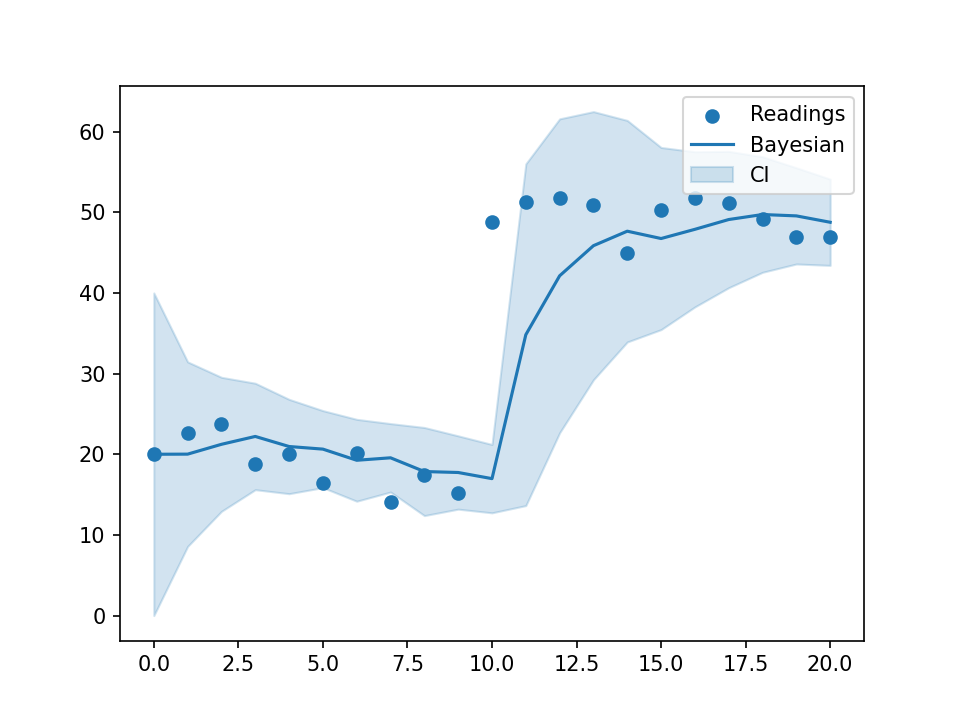

In [4]:
trend = [20 for x in range(10)] + [50 for x in range(10)]
readings = [t + 3 * np.random.normal() for t in trend]

xs = []
lowers = []
means = []
uppers = []

elos = []

r = Rating(prior_n=1, prior_mean=20, prior_sd=10, decay=0.7)
elo = 20
for i, t in enumerate(readings):
    mean, sd = r.t_distrib().mean(), r.t_distrib().sd()
    xs.append(i)
    
    elos.append(elo)
        
    r.add(t)
    
    if i == 9:
        for _ in range(3):
            r.decay()
    
    error = t - elo
    elo += error * 0.3
    
fig, ax = plt.subplots()
r.plot_history(ax=ax)

<IPython.core.display.Javascript object>


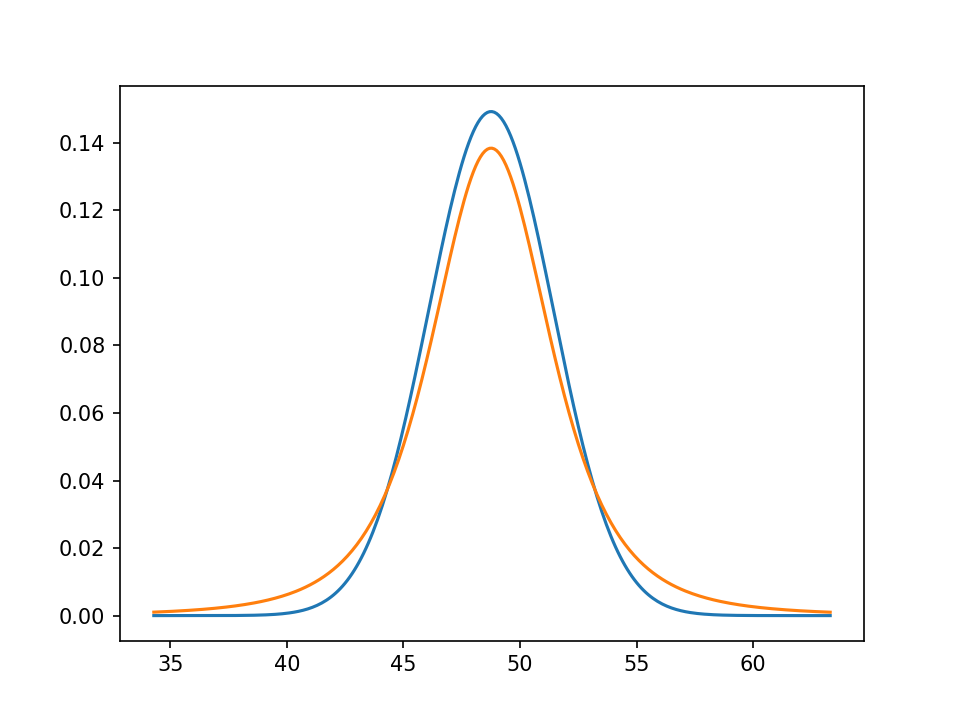

In [5]:
dist1 = r.n_distrib()
dist2 = r.t_distrib()
Distrib.fig_list([dist1, dist2])